In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
import pandas as pd

In [3]:
images_path = '../data/resized_and_user_images'
labels_path = '../data/resized_and_user_labels.csv'

In [4]:
y = pd.read_csv(labels_path, index_col='filename')

def get_y_func(x):
    filename = str(x).split('/')[-1]
    zipped = zip(list(y.loc[filename])[0::2], list(y.loc[filename])[1::2])
    return tensor(list(zipped))

In [5]:
dblock = DataBlock(
    get_items=get_image_files,
    blocks=(ImageBlock, PointBlock),
    splitter=RandomSplitter(valid_pct=0.15),
    get_y=get_y_func,
    batch_tfms=[
        *aug_transforms(
            do_flip=False,
            size=(160,160), 
            max_rotate=15,
            max_lighting=0.5,
            max_warp=0.4
        ),
        Normalize.from_stats(*imagenet_stats)
    ]
)

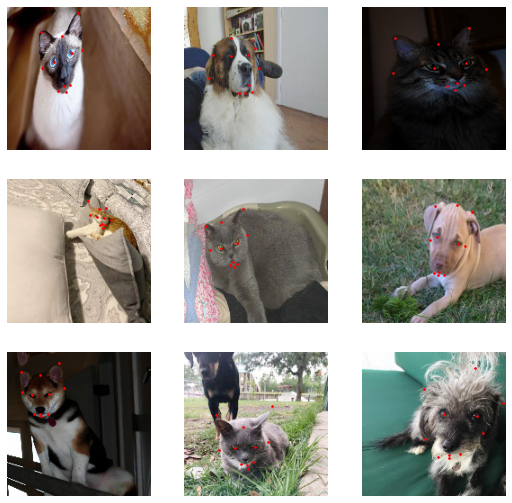

In [6]:
dls = dblock.dataloaders(images_path, bs=32)
dls.c = dls.train.after_item.c
dls.show_batch()

In [7]:
learn = cnn_learner(
    dls, 
    resnet18, 
    loss_func=MSELossFlat(), 
    opt_func=ranger
).to_fp16(clip=0.1)

In [8]:
learn.freeze_to(-1)

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.17378008365631104)

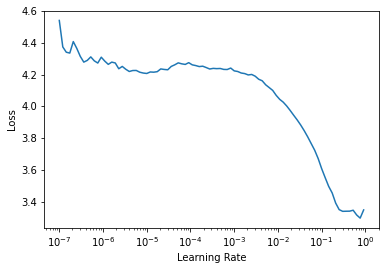

In [9]:
learn.lr_find()

In [10]:
learn.fit_flat_cos(
    5, 
    1e-2
)

epoch,train_loss,valid_loss,time
0,0.251107,0.150104,00:33
1,0.116999,0.075650,00:33
2,0.072209,0.050384,00:33
3,0.056305,0.042026,00:32
4,0.050487,0.037269,00:32


In [11]:
learn.unfreeze()

SuggestedLRs(lr_min=2.0892961401841602e-06, lr_steep=6.309573450380412e-07)

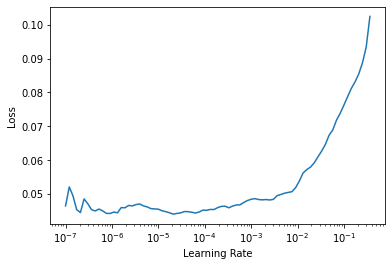

In [12]:
learn.lr_find()

In [14]:
learn.fit_flat_cos(
    50, 
    5e-5, 
    cbs=[
        SaveModelCallback(), 
        ShowGraphCallback(),
        CSVLogger()
    ]
)

In [15]:
learn = learn.load('model')

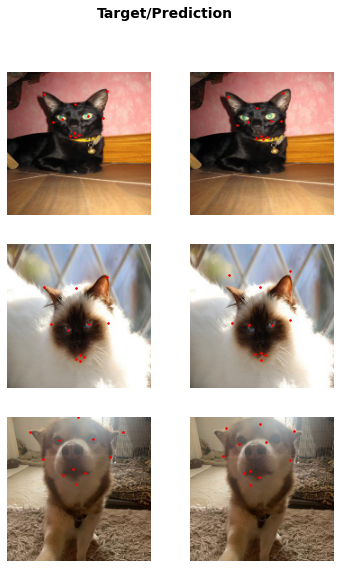

In [18]:
learn.show_results()

In [18]:
# learn.predict(pet_dataloaders.train_ds.items[0])

In [24]:
# learn.summary()

In [52]:
# learn.export('models/export.pkl')

In [16]:
# learn = load_learner('../models/export.pkl')